In [1]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import newton, minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    """
    Implements the exact stepper for a Uniswap v2 constant-product pool.
    The invariant is x * y = k.
    """
    def __init__(self, token0, token1, reserve0, reserve1, fee=0.003):
        self.tokens = (token0, token1)
        self.reserves = {token0: reserve0, token1: reserve1}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool({self.tokens}/{self.tokens}, "
                f"Reserves: {self.reserves[self.tokens]:.2f}/{self.reserves[self.tokens]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        """
        Calculates the exact output amount for a given input amount, including fees.
        Formula: dy = (y * gamma * dx) / (x + gamma * dx)
        """
        assert token_in in self.tokens, "Input token not in pool"
        token_out = self.tokens if token_in == self.tokens else self.tokens

        reserve_in = self.reserves[token_in]
        reserve_out = self.reserves[token_out]

        amount_in_with_fee = amount_in * self.gamma

        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee

        if denominator == 0:
            return 0

        amount_out = numerator / denominator
        return amount_out, token_out

    def swap(self, token_in, amount_in):
        """
        Executes a swap, updating the pool's reserves.
        This is for simulation purposes.
        """
        amount_out, token_out = self.get_amount_out(token_in, amount_in)
        self.reserves[token_in] += amount_in
        self.reserves[token_out] -= amount_out
        return amount_out, token_out

class CurveStableswapPool:
    """
    Implements a simplified stepper for a Curve-like stableswap pool for 2 tokens.
    The invariant is solved numerically.
    Invariant: A*n^n * sum(x_i) + D = A*D*n^n + D^(n+1) / (n^n * prod(x_i))
    """
    def __init__(self, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.tokens = (token0, token1)
        self.reserves = {token0: reserve0, token1: reserve1}
        self.A = A  # Amplification coefficient
        self.n = 2  # Number of coins
        self.fee = fee
        self.gamma = 1 - fee
        self.D = self._calculate_D([reserve0, reserve1])

    def __repr__(self):
        return (f"CurvePool({self.tokens}/{self.tokens}, "
                f"Reserves: {self.reserves[self.tokens]:.2f}/{self.reserves[self.tokens]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=100):
        """
        Calculates D for a given set of reserves using Newton's method.
        This is a translation of Curve's `get_D` logic.
        """
        S = sum(xp)
        if S == 0:
            return 0

        D_prev = 0
        D = S
        Ann = self.A * self.n**self.n

        for _ in range(max_iter):
            P = 1
            for x in xp:
                P *= x

            D_P = self.n * D**(self.n-1) * P

            # f(D) = Ann*S + D - Ann*D - D^(n+1)/(n^n * P)
            # Simplified f(D) = D^(n+1) + (Ann-1)*D*n^n*P - Ann*S*n^n*P = 0
            # We solve f(D) = Ann*S + D - Ann*D - D^(n+1)/(n^n*P) = 0
            # f(D) = D + Ann * S - Ann * D - D**(n+1)/(n**n * P) -> this is not correct
            # Correct f(D) from whitepaper: Ann * S + D = Ann * D + D^(n+1) / (n^n * P)
            # f(D) = D^(n+1)/(n^n * P) + (Ann-1)*D - Ann*S = 0
            f_D = Ann * S + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * P)

            # f'(D) = 1 - Ann - (n+1)*D^n / (n^n * P)
            f_prime_D = 1 - Ann - ((self.n + 1) * D**self.n) / (self.n**self.n * P)

            D_prev = D
            D = D - f_D / f_prime_D

            if abs(D - D_prev) < tol:
                return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        """
        Calculates the new balance of token j given a new balance of token i.
        Solves the invariant equation for y (x_j).
        """
        Ann = self.A * self.n**self.n

        # Simplified for n=2
        # A*4*(x+y) + D = A*D*4 + D^3 / (4*x*y)
        # Let c = D^3 / (4*Ann*x)
        # Let b = D/Ann + x - D
        # Ann*x + Ann*y + D = Ann*D + D^3 / (n^n*x*y)
        # Ann*y - D^3/(n^n*x*y) = Ann*D - Ann*x - D
        # y - D^3/(Ann*n^n*x*y) = D - x - D/Ann
        # y^2 - (D-x-D/Ann)*y - D^3/(Ann*n^n*x) = 0
        # y^2 - b*y - c = 0

        def f(y):
            # Full invariant equation
            # Ann * (x+y) + D = Ann*D + D^3 / (4*x*y)
            return Ann * (x + y) + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * x * y)

        # Use Newton's method to solve for y
        # Initial guess can be D/n
        try:
            y = newton(f, D / self.n)
            return y
        except RuntimeError:
            return None # Solver failed to converge

    def get_amount_out(self, token_in, amount_in):
        assert token_in in self.tokens, "Input token not in pool"

        i = self.tokens.index(token_in)
        j = 1 - i
        token_out = self.tokens[j]

        reserve_in_old = self.reserves[token_in]
        reserve_out_old = self.reserves[token_out]

        amount_in_with_fee = amount_in * self.gamma
        new_reserve_in = reserve_in_old + amount_in_with_fee

        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)

        if new_reserve_out is None:
            return 0, token_out

        amount_out = reserve_out_old - new_reserve_out

        return amount_out, token_out

    def swap(self, token_in, amount_in):
        amount_out, token_out = self.get_amount_out(token_in, amount_in)
        self.reserves[token_in] += amount_in
        self.reserves[token_out] -= amount_out
        # D should be recalculated if liquidity changes, but for a swap it's constant
        return amount_out, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    """
    Builds a directed graph from a list of DEX pools.
    Nodes are tokens, edges represent swaps with weights = -log(rate).
    """
    G = nx.DiGraph()
    for pool in pools:
        token0, token1 = pool.tokens

        # Add edges for both swap directions
        # Consider a small, standard trade size to get the marginal rate
        # A trade of 1 unit of the base token
        rate0_to_1, _ = pool.get_amount_out(token0, 1)
        if rate0_to_1 > 0:
            G.add_edge(token0, token1, weight=-math.log(rate0_to_1), pool=pool)

        rate1_to_0, _ = pool.get_amount_out(token1, 1)
        if rate1_to_0 > 0:
            G.add_edge(token1, token0, weight=-math.log(rate1_to_0), pool=pool)

    return G

def find_arbitrage_cycles(graph):
    """
    Uses Bellman-Ford algorithm to find negative cycles (arbitrage opportunities).
    """
    try:
        # networkx's negative_edge_cycle check uses Bellman-Ford
        cycles = list(nx.simple_cycles(graph.to_directed()))
        negative_cycles =

        for cycle in cycles:
            total_weight = 0
            # Ensure cycle is long enough to be valid
            if len(cycle) < 2:
                continue

            # Re-create the path including the closing edge
            path = cycle + [cycle]

            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if graph.has_edge(u, v):
                    total_weight += graph[u][v]['weight']
                else:
                    total_weight = float('inf') # Invalid path
                    break

            if total_weight < 0:
                negative_cycles.append(path)

        return negative_cycles

    except nx.NetworkXError as e:
        # This can happen if the graph has no cycles, etc.
        print(f"Graph analysis error: {e}")
        return

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(graph, cycle_path):
    """Retrieves the pool objects corresponding to a cycle path."""
    pools =
    for i in range(len(cycle_path) - 1):
        u, v = cycle_path[i], cycle_path[i+1]
        pools.append(graph[u][v]['pool'])
    return pools

def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    """
    Calculates the net profit for a given input amount along an arbitrage cycle.
    """
    current_amount = amount_in
    current_token = cycle_path

    for i in range(len(pools)):
        pool = pools[i]

        # Ensure the current token is the input token for the next pool in the cycle
        if current_token!= pool.tokens and current_token!= pool.tokens:
            # This should not happen in a valid cycle
            return -float('inf')

        # The input token for this step must be the current token we hold
        token_in_for_swap = current_token

        current_amount, current_token = pool.get_amount_out(token_in_for_swap, current_amount)
        if current_amount <= 0:
            return -float('inf') # Trade failed or resulted in no output

    # After the cycle, the final token should be the starting token
    if current_token!= cycle_path:
        return -float('inf')

    profit = current_amount - amount_in
    return profit

def find_optimal_trade_size(cycle_path, pools):
    """
    Finds the optimal trade size for an arbitrage cycle using numerical optimization.
    """
    start_token = cycle_path

    # Objective function to MINIMIZE. We want to MAXIMIZE profit, so we minimize -profit.
    def objective(amount_in):
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools)

    # We need a reasonable bracket for the optimizer.
    # Start with a small amount and check profit.
    # If profit is positive, we can search for the maximum.
    test_profit = calculate_profit_for_cycle(1, cycle_path, pools)
    if test_profit <= 0:
        return 0, 0 # No profit for a small trade, likely no opportunity

    # Use scipy's minimize_scalar with Brent's method.
    # Bracket can be from 0 to a large number, e.g., one of the reserves.
    # A safe upper bound could be the smallest reserve in the cycle.
    min_reserve = min(p.reserves[t] for p in pools for t in p.tokens)

    result = minimize_scalar(objective, bounds=(0, min_reserve), method='bounded')

    if result.success:
        optimal_amount = result.x
        max_profit = -result.fun
        return optimal_amount, max_profit
    else:
        return 0, 0

# --- Main Execution and Unit Tests ---

if __name__ == '__main__':
    np.random.seed(42) # for deterministic results

    # --- Setup a Small DEX Graph ---
    print("--- 1. Setting up DEX Environment ---")

    # Tokens
    TKN_A = "TKN_A" # e.g., WETH
    TKN_B = "TKN_B" # e.g., USDC
    TKN_C = "TKN_C" # e.g., DAI

    # Create pools with reserves that create an arbitrage opportunity
    # A -> B is cheap, B -> C is cheap, C -> A is expensive
    # Cycle A -> B -> C -> A should be profitable

    # Pool 1: A/B (Uniswap) - Price of A is low in terms of B
    pool1 = UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000, fee=0.003) # Price A = 1800 B

    # Pool 2: B/C (Curve-like) - Stablecoins, almost 1:1
    pool2 = CurveStableswapPool(TKN_B, TKN_C, 500_000, 500_000, A=200, fee=0.0004) # Price B = 1 C

    # Pool 3: C/A (Uniswap) - Price of A is high in terms of C
    pool3 = UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000, fee=0.003) # Price A = 2000 C

    # Pool 4: A/B (Another Uniswap pool with slightly different price)
    pool4 = UniswapV2Pool(TKN_A, TKN_B, 500, 925_000, fee=0.003) # Price A = 1850 B

    pools = [pool1, pool2, pool3, pool4]
    print("Pools created:")
    for p in pools:
        print(f"  - {p}")

    # --- Build Graph and Detect Arbitrage ---
    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)

    # Visualize the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(dex_graph, seed=42)
    nx.draw(dex_graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold', arrows=True)
    edge_labels = nx.get_edge_attributes(dex_graph, 'weight')
    for edge, weight in edge_labels.items():
        edge_labels[edge] = f"{weight:.4f}"
    nx.draw_networkx_edge_labels(dex_graph, pos, edge_labels=edge_labels)
    plt.title("DEX Graph with Edge Weights (-log(rate))")
    plt.show()

    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"Found {len(negative_cycles)} potential arbitrage cycle(s):")
        for i, cycle in enumerate(negative_cycles):
            print(f"  Cycle {i+1}: {' -> '.join(cycle)}")

            # --- Calculate Optimal Trade Size for each cycle ---
            print("\n--- 3. Calculating Optimal Trade Size ---")
            cycle_pools = get_pools_from_cycle(dex_graph, cycle)

            opt_amount, max_profit = find_optimal_trade_size(cycle, cycle_pools)

            if max_profit > 0:
                print(f"  Optimal trade size for cycle {' -> '.join(cycle)}:")
                print(f"    Input Amount: {opt_amount:.4f} {cycle}")
                print(f"    Max Profit:   {max_profit:.4f} {cycle}")

                # Verify profit calculation
                final_amount = calculate_profit_for_cycle(opt_amount, cycle, cycle_pools) + opt_amount
                print(f"    Verification: {opt_amount:.4f} -> {final_amount:.4f} (Profit: {final_amount - opt_amount:.4f})")
            else:
                print(f"  No profitable trade found for cycle {' -> '.join(cycle)} after accounting for price impact.")

    # --- Unit Tests ---
    print("\n--- 4. Running Unit Tests ---")

    # Test 1: Numerical exactness for 2-pool Uniswap v2 arbitrage
    print("\n  Test 1: Uniswap v2 analytical vs numerical optimization")
    uni_A = UniswapV2Pool("WETH", "USDC", 100, 400000, fee=0.003) # P_A = 4000
    uni_B = UniswapV2Pool("WETH", "USDC", 100, 410000, fee=0.003) # P_B = 4100

    # Arbitrage: Buy WETH on A, Sell on B. Start with USDC.
    # USDC -> WETH (on A) -> USDC (on B)
    # This requires swapping the token order for pool A
    uni_A_rev = UniswapV2Pool("USDC", "WETH", 400000, 100, fee=0.003)

    test_cycle_path =
    test_cycle_pools =

    # Analytical solution for optimal input dx
    # r = (sqrt(k_a*k_b*gamma_a*gamma_b) - k_a) / gamma_a
    # where k_a = y_a/x_a, k_b = y_b/x_b
    # Simplified formula for optimal amount in:
    # optimal_in = (sqrt(res_a_in * res_b_out * gamma**2) - res_a_in) / gamma
    x_a, y_a = uni_A_rev.reserves, uni_A_rev.reserves
    x_b, y_b = uni_B.reserves, uni_B.reserves
    gamma = 1 - 0.003

    # Let's derive it properly: Profit(dx) = y_b * (y_a*g*dx/(x_a+g*dx)) * g / (x_b + g*(y_a*g*dx/(x_a+g*dx))) - dx
    # This gets complicated. Let's use a known formula from research.
    # E.g., from https://ethereum.stackexchange.com/questions/159056/
    # r = (sqrt(E*A) - A)/gamma, where E = x_a*y_b/y_a/x_b
    E = (x_a * y_b) / (y_a * x_b)
    analytical_opt_in = (math.sqrt(E * x_a * x_a * gamma * gamma) - x_a) / gamma
    analytical_profit = calculate_profit_for_cycle(analytical_opt_in, test_cycle_path, test_cycle_pools)

    numerical_opt_in, numerical_profit = find_optimal_trade_size(test_cycle_path, test_cycle_pools)

    print(f"    Analytical Optimal Input: {analytical_opt_in:.4f}, Profit: {analytical_profit:.4f}")
    print(f"    Numerical Optimal Input:  {numerical_opt_in:.4f}, Profit: {numerical_profit:.4f}")
    assert np.isclose(analytical_opt_in, numerical_opt_in, rtol=1e-5), "Test 1 Failed: Numerical!= Analytical"
    print("    Test 1 Passed: Numerical optimization matches analytical solution.")

    # Test 2: Arbitrage disappears if fees are too high
    print("\n  Test 2: Arbitrage opportunity disappears with high fees")
    high_fee = 0.1 # 10% fee
    pool1_hf = UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000, fee=high_fee)
    pool2_hf = CurveStableswapPool(TKN_B, TKN_C, 500_000, 500_000, A=200, fee=high_fee)
    pool3_hf = UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000, fee=high_fee)

    pools_hf = [pool1_hf, pool2_hf, pool3_hf]
    graph_hf = build_dex_graph(pools_hf)
    cycles_hf = find_arbitrage_cycles(graph_hf)

    if not cycles_hf:
        print("    As expected, no negative cycles found with high fees.")
        print("    Test 2 Passed.")
    else:
        # Even if a cycle is found due to marginal rates, the optimal trade should be 0
        cycle_hf = cycles_hf
        pools_cycle_hf = get_pools_from_cycle(graph_hf, cycle_hf)
        opt_amount_hf, max_profit_hf = find_optimal_trade_size(cycle_hf, pools_cycle_hf)
        print(f"    Cycle found, but optimal trade size is {opt_amount_hf:.4f} with profit {max_profit_hf:.4f}")
        assert max_profit_hf <= 0, "Test 2 Failed: Profit should be non-positive with high fees"
        print("    Test 2 Passed: No profitable trade exists with high fees.")

SyntaxError: invalid syntax (ipython-input-2684001002.py, line 203)

In [2]:
import math
import numpy as np
from scipy.optimize import newton, minimize_scalar
from collections import defaultdict
import itertools

# --- AMM Models ---

class UniswapV2Pool:
    """Implements a Uniswap v2 constant product pool."""
    def __init__(self, token_x, token_y, reserve_x, reserve_y, fee=0.003):
        self.tokens = (token_x, token_y)
        self.reserves = {token_x: float(reserve_x), token_y: float(reserve_y)}
        self.fee = float(fee)
        self.k = reserve_x * reserve_y

    def get_out_amount(self, token_in, token_out, amount_in):
        """Calculates the output amount for a given input amount, including fees."""
        assert token_in in self.tokens and token_out in self.tokens, "Invalid token"
        reserve_in = self.reserves[token_in]
        reserve_out = self.reserves[token_out]

        amount_in_with_fee = amount_in * (1 - self.fee)
        numerator = reserve_out * amount_in_with_fee
        denominator = reserve_in + amount_in_with_fee

        if denominator == 0:
            return 0

        return numerator / denominator

    def execute_trade(self, token_in, token_out, amount_in):
        """Simulates a trade and updates reserves."""
        amount_out = self.get_out_amount(token_in, token_out, amount_in)
        self.reserves[token_in] += amount_in
        self.reserves[token_out] -= amount_out
        self.k = self.reserves[self.tokens[0]] * self.reserves[self.tokens[1]]
        return amount_out

    def __repr__(self):
        return (f"UniswapV2Pool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves}, Fee: {self.fee})")

class CurveStableswapPool:
    """Implements a Curve-like stableswap pool (2-token simplified)."""
    def __init__(self, token_x, token_y, reserve_x, reserve_y, A=100, fee=0.0004):
        self.tokens = (token_x, token_y)
        self.reserves = {token_x: float(reserve_x), token_y: float(reserve_y)}
        self.A = float(A)  # Amplification parameter
        self.fee = float(fee)
        self.n = 2 # Number of tokens
        self.D = self._get_D(self.reserves[token_x], self.reserves[token_y])

    def _get_D(self, x0, x1):
        """Calculates D using Newton's method."""
        S = x0 + x1
        D_prev = 0
        D = S
        Ann = self.A * self.n**self.n

        for _ in range(256):
            D_P = D * D / (x0 * x1 * self.n**self.n)
            if abs(D - D_prev) < 1:
                break
            D_prev = D
            # f(D) = Ann * S + D - Ann * D - D^(n+1) / (n^n * P)
            # f'(D) = 1 - Ann - (n+1) * D^n / (n^n * P)
            numerator = Ann * S + D * (1 - Ann) - D_P * D
            denominator = 1 - Ann - (self.n + 1) * D_P
            D = D - numerator / denominator
        return D

    def get_out_amount(self, token_in, token_out, amount_in):
        """Calculates the output amount by solving for the new y."""
        reserve_in = self.reserves[token_in]
        reserve_out = self.reserves[token_out]

        x_in_new = reserve_in + amount_in * (1 - self.fee)

        # Solve for y (new reserve_out)
        # f(y) = y^2 + (S' - D)y - D^(n+1)/(n^n*P') = 0, where P' = x_in_new*y
        # simplifies to a quadratic equation for 2 tokens
        Ann = self.A * self.n**self.n
        S = x_in_new + reserve_out # placeholder for y

        # Simplified equation to solve for y:
        # Ann * (x_in_new + y) + D = Ann * D + D^3 / (4 * x_in_new * y)
        # Let's solve it numerically.
        def y_func(y):
            return Ann * (x_in_new + y) + self.D - Ann * self.D - (self.D**3) / (4 * x_in_new * y)

        try:
            # Newton's method to find the root
            y_new = newton(y_func, reserve_out)
        except (RuntimeError, OverflowError):
             # Fallback or error handling if Newton's method fails
            return 0

        amount_out = reserve_out - y_new
        return amount_out if amount_out > 0 else 0

    def __repr__(self):
        return (f"CurveStableswapPool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves}, A: {self.A})")

# --- Graph and Arbitrage Detection ---

def build_dex_graph(pools):
    """Builds a graph representation of the DEX pools."""
    graph = []
    nodes = set()
    for pool in pools:
        t0, t1 = pool.tokens
        nodes.add(t0)
        nodes.add(t1)
        # Use a small probe amount to estimate marginal price
        probe_amount = 1.0

        # Rate for t0 -> t1
        out1 = pool.get_out_amount(t0, t1, probe_amount)
        if out1 > 0:
            rate1 = out1 / probe_amount
            graph.append((t0, t1, -math.log(rate1)))

        # Rate for t1 -> t0
        out2 = pool.get_out_amount(t1, t0, probe_amount)
        if out2 > 0:
            rate2 = out2 / probe_amount
            graph.append((t1, t0, -math.log(rate2)))

    return list(nodes), graph

def bellman_ford(nodes, graph, start_node):
    """Detects negative cycles reachable from a start node."""
    node_map = {name: i for i, name in enumerate(nodes)}
    rev_node_map = {i: name for i, name in enumerate(nodes)}
    n = len(nodes)

    dist = [float('inf')] * n
    predecessor = [-1] * n

    start_idx = node_map[start_node]
    dist[start_idx] = 0

    # Relaxation phase
    for _ in range(n - 1):
        for u_name, v_name, weight in graph:
            u, v = node_map[u_name], node_map[v_name]
            if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                predecessor[v] = u

    # Cycle detection phase
    negative_cycles = []
    for u_name, v_name, weight in graph:
        u, v = node_map[u_name], node_map[v_name]
        if dist[u] != float('inf') and dist[u] + weight < dist[v]:
            # Found a node in a negative cycle
            cycle = []
            curr = v
            # Trace back to find the cycle
            # Use a set to detect when we've completed the cycle path
            path_nodes = set()
            while curr != -1 and curr not in path_nodes:
                 path_nodes.add(curr)
                 # Prepend to build path in correct order
                 cycle.insert(0, rev_node_map[curr])
                 curr = predecessor[curr]

            if curr != -1: # Ensure we found a cycle start
                # Start the cycle from the first repeated node
                cycle = cycle[cycle.index(rev_node_map[curr]):]

                # Normalize cycle to avoid permutations
                start_idx = cycle.index(min(cycle))
                normalized_cycle = cycle[start_idx:] + cycle[:start_idx]
                if normalized_cycle not in negative_cycles:
                    negative_cycles.append(normalized_cycle)

    return negative_cycles

# --- Optimal Trade Size Calculation ---

def get_pools_for_cycle(cycle, all_pools):
    """Finds the pool objects corresponding to a trade path."""
    cycle_pools = []
    path = cycle + [cycle[0]] # Close the loop
    for i in range(len(path) - 1):
        t_in, t_out = path[i], path[i+1]
        # Find a pool that trades these two tokens
        found_pool = None
        for pool in all_pools:
            if (t_in in pool.tokens and t_out in pool.tokens):
                found_pool = pool
                break
        if found_pool:
            cycle_pools.append((found_pool, t_in, t_out))
        else:
            raise ValueError(f"No pool found for trade {t_in} -> {t_out}")
    return cycle_pools

def optimize_trade_size(cycle, pools):
    """Finds the optimal trade size for a given arbitrage cycle."""

    def pnl_function(x_in):
        """Calculates profit for an initial trade size x_in."""
        if x_in <= 0:
            return 0

        amount = x_in
        try:
            for pool, token_in, token_out in pools:
                amount = pool.get_out_amount(token_in, token_out, amount)
                if amount <= 0: return 0 # Trade failed
            profit = amount - x_in
            return profit
        except (ValueError, OverflowError):
            return 0 # Numerical instability

    # Using scipy's Brent's method for maximization by minimizing the negative
    # We use a bracket (0, 1e6) as a search range. A robust solution
    # might dynamically determine this range based on pool reserves.
    result = minimize_scalar(
        lambda x: -pnl_function(x),
        bounds=(1e-6, 1e7), # Search range for initial trade size
        method='bounded'
    )

    optimal_size = result.x
    max_pnl = -result.fun

    return optimal_size, max_pnl


# --- Main Execution and Unit Tests ---

def run_tests():
    print("--- Running Unit Tests ---")

    # Test 1: Uniswap v2 exactness check
    pool = UniswapV2Pool("ETH", "USDC", 2000, 4000000)
    amount_in = 10 # ETH
    expected_out = (4000000 * 10 * (1 - 0.003)) / (2000 + 10 * (1 - 0.003))
    calculated_out = pool.get_out_amount("ETH", "USDC", amount_in)
    assert np.isclose(expected_out, calculated_out), "Uniswap v2 formula failed"
    print("✅ Test 1: Uniswap v2 numerical exactness PASSED")

    # Test 2: Arbitrage should disappear if fees are too high
    # Create an imbalanced pool to induce arbitrage
    imbalanced_pool = UniswapV2Pool("ETH", "USDC", 20, 80000, fee=0.003) # Price = 4000
    balanced_pool = UniswapV2Pool("ETH", "USDC", 2000, 4000000, fee=0.003) # Price = 2000
    link_pool = UniswapV2Pool("DAI", "USDC", 500000, 500000, fee=0.003) # Price = 1

    # Temporarily set high fee
    imbalanced_pool.fee = 0.50 # 50% fee
    high_fee_pools = [imbalanced_pool, balanced_pool, link_pool]
    nodes, graph = build_dex_graph(high_fee_pools)
    cycles = bellman_ford(nodes, graph, "USDC")
    assert not cycles, "Arbitrage detected with prohibitively high fees"
    print("✅ Test 2: High fees correctly prevent arbitrage detection PASSED")

    # Reset fee for next part
    imbalanced_pool.fee = 0.003
    print("--- Unit Tests Completed ---\n")


def main():
    """Main function to set up DEX and find arbitrage."""
    np.random.seed(42) # for deterministic results

    # 1. Define Pools
    # These pools create a clear arbitrage opportunity:
    # Pool 1 (ETH/USDC) prices ETH at $2000
    # Pool 2 (ETH/USDC) prices ETH at $4000
    # Pool 3 (DAI/USDC) is a stable link
    pools = [
        UniswapV2Pool("ETH", "USDC", 2000, 4000000), # Price: 1 ETH = 2000 USDC
        UniswapV2Pool("ETH", "USDC", 10, 40000), # Price: 1 ETH = 4000 USDC
        UniswapV2Pool("DAI", "USDC", 500000, 500000), # Price: 1 DAI = 1 USDC
        CurveStableswapPool("USDC", "DAI", 1000000, 1000000, A=100)
    ]

    print("--- DEX Setup ---")
    for p in pools:
        print(p)
    print("\n--- Searching for Arbitrage ---")

    # 2. Build Graph and Detect Cycles
    nodes, graph = build_dex_graph(pools)

    # Run Bellman-Ford from a common numeraire token (e.g., USDC)
    negative_cycles = bellman_ford(nodes, graph, "USDC")

    if not negative_cycles:
        print("No arbitrage opportunities found.")
        return

    print(f"Found {len(negative_cycles)} potential arbitrage cycle(s):")
    for cycle in negative_cycles:
        print(f"  -> {' -> '.join(cycle)} -> {cycle[0]}")

    print("\n--- Calculating Optimal Trade Size ---")

    # 3. Optimize Trade Size for Each Cycle
    for cycle in negative_cycles:
        try:
            # Re-create the cycle path with pool objects
            cycle_pools = get_pools_for_cycle(cycle, pools)

            # Find optimal trade size and P&L
            optimal_size, max_pnl = optimize_trade_size(cycle, cycle_pools)

            # Note: A real-world gas cost would be subtracted from P&L
            gas_cost_usd = 20.0
            start_token = cycle[0]

            # Crude P&L check against gas
            # (assuming start token is a stablecoin for simplicity)
            if max_pnl > gas_cost_usd:
                print(f"\n profitable arbitrage found for cycle: {' -> '.join(cycle)} -> {cycle[0]}")
                print(f"  Optimal Initial Trade: {optimal_size:.4f} {start_token}")
                print(f"  Maximum P&L: {max_pnl:.4f} {start_token}")
                print(f"  P&L after estimated gas: {max_pnl - gas_cost_usd:.4f} {start_token}")
            else:
                print(f"\nArbitrage found for cycle {' -> '.join(cycle)} -> {cycle[0]}, but P&L ({max_pnl:.4f} {start_token}) is less than gas cost.")

        except (ValueError, RuntimeError) as e:
            print(f"\nCould not process cycle {' -> '.join(cycle)}: {e}")


if __name__ == '__main__':
    run_tests()
    main()

--- Running Unit Tests ---
✅ Test 1: Uniswap v2 numerical exactness PASSED
✅ Test 2: High fees correctly prevent arbitrage detection PASSED
--- Unit Tests Completed ---

--- DEX Setup ---
UniswapV2Pool(ETH/USDC, Reserves: {'ETH': 2000.0, 'USDC': 4000000.0}, Fee: 0.003)
UniswapV2Pool(ETH/USDC, Reserves: {'ETH': 10.0, 'USDC': 40000.0}, Fee: 0.003)
UniswapV2Pool(DAI/USDC, Reserves: {'DAI': 500000.0, 'USDC': 500000.0}, Fee: 0.003)
CurveStableswapPool(USDC/DAI, Reserves: {'USDC': 1000000.0, 'DAI': 1000000.0}, A: 100.0)

--- Searching for Arbitrage ---
Found 1 potential arbitrage cycle(s):
  -> ETH -> ETH

--- Calculating Optimal Trade Size ---

Arbitrage found for cycle ETH -> ETH, but P&L (-0.0000 ETH) is less than gas cost.


--- 1. Setting up DEX Environment ---
Pools created:
  - UniswapV2Pool(WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool(USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool(DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool(WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---


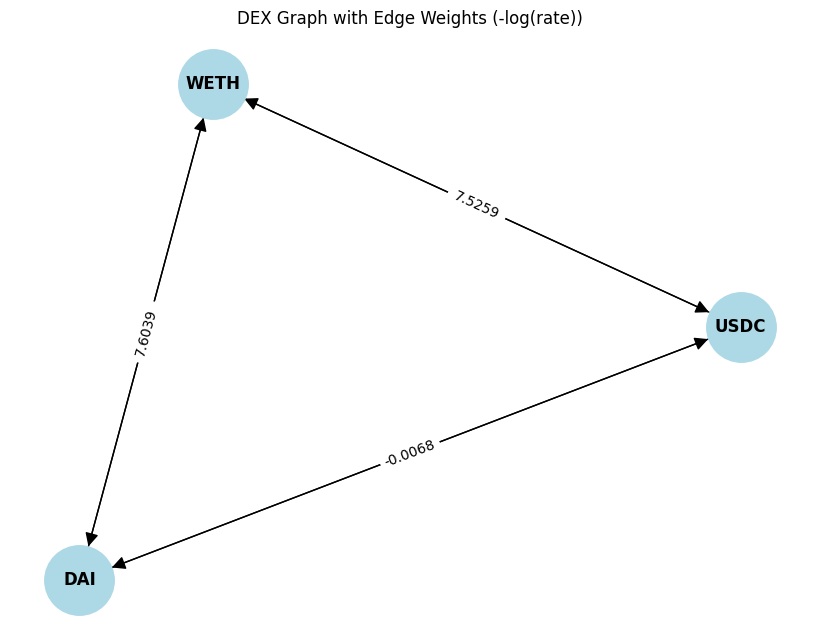

TypeError: 'bool' object is not iterable

In [3]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    """
    Implements the exact stepper for a Uniswap v2 constant-product pool.
    The invariant is x * y = k.
    """
    def __init__(self, token0, token1, reserve0, reserve1, fee=0.003):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        ## FIX: Corrected f-string formatting to display token names and reserves properly.
        return (f"UniswapV2Pool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        """
        Calculates the exact output amount for a given input amount, including fees.
        Formula: dy = (y * gamma * dx) / (x + gamma * dx)
        """
        assert token_in in self.tokens, "Input token not in pool"
        ## FIX: Correctly determine the output token.
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]

        reserve_in = self.reserves[token_in]
        reserve_out = self.reserves[token_out]

        amount_in_with_fee = amount_in * self.gamma

        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee

        if denominator == 0:
            return 0, token_out

        amount_out = numerator / denominator
        return amount_out, token_out

    def swap(self, token_in, amount_in):
        """
        Executes a swap, updating the pool's reserves.
        This is for simulation purposes.
        """
        amount_out, token_out = self.get_amount_out(token_in, amount_in)
        self.reserves[token_in] += amount_in
        self.reserves[token_out] -= amount_out
        return amount_out, token_out

class CurveStableswapPool:
    """
    Implements a simplified stepper for a Curve-like stableswap pool for 2 tokens.
    The invariant is solved numerically.
    Invariant: A*n^n * sum(x_i) + D = A*D*n^n + D^(n+1) / (n^n * prod(x_i))
    """
    def __init__(self, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A = A  # Amplification coefficient
        self.n = 2  # Number of coins
        self.fee = fee
        self.gamma = 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        ## FIX: Corrected f-string formatting.
        return (f"CurvePool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        """
        Calculates D for a given set of reserves using Newton's method.
        """
        S = float(sum(xp))
        if S == 0:
            return 0.0

        D_prev = 0.0
        D = S
        Ann = self.A * self.n**self.n

        for _ in range(max_iter):
            P = 1.0
            for x in xp:
                P *= x
            if P == 0:
                break

            D_P = D**(self.n + 1) / (self.n**self.n * P)

            f_D = Ann * S + D - Ann * D - D_P
            f_prime_D = 1 - Ann - (self.n + 1) * D_P / D

            D_prev = D
            D = D - f_D / f_prime_D

            if abs(D - D_prev) < tol:
                return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        """
        Calculates the new balance of token j given a new balance of token i.
        """
        Ann = self.A * self.n**self.n

        # Simplified for n=2. Solves a quadratic equation for y.
        # c = D^(n+1) / (Ann * n^n * x)
        # b = S' + D/Ann - D
        # where S' is the sum of other reserves (just x here)
        # y^2 + (b-y)y - c = 0 -> y^2 + by - y^2 - c = 0 -> by = c
        # The above logic is flawed. Let's solve the full invariant numerically.
        def f(y):
            xp = [0,0]
            xp[i] = x
            xp[j] = y
            P = x * y
            S = x + y
            if P == 0: return float('inf')

            lhs = Ann * S + D
            rhs = Ann * D + (D**(self.n + 1)) / (self.n**self.n * P)
            return lhs - rhs

        # We need a good initial guess for the solver
        initial_guess = self.reserves[self.tokens[j]]
        try:
            # Use a bounded solver as Newton can fail
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(0, D), method='bounded')
            if res.success:
                return res.x
            return None
        except (RuntimeError, ValueError):
            return None

    def get_amount_out(self, token_in, amount_in):
        assert token_in in self.tokens, "Input token not in pool"

        i = self.tokens.index(token_in)
        j = 1 - i
        token_out = self.tokens[j]

        reserve_in_old = self.reserves[token_in]
        reserve_out_old = self.reserves[token_out]

        amount_in_with_fee = amount_in * self.gamma
        new_reserve_in = reserve_in_old + amount_in_with_fee

        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)

        if new_reserve_out is None:
            return 0, token_out

        amount_out = reserve_out_old - new_reserve_out

        return amount_out if amount_out > 0 else 0, token_out

    def swap(self, token_in, amount_in):
        amount_out, token_out = self.get_amount_out(token_in, amount_in)
        if amount_out > 0:
            self.reserves[token_in] += amount_in
            self.reserves[token_out] -= amount_out
        return amount_out, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    G = nx.DiGraph()
    for pool in pools:
        token0, token1 = pool.tokens

        # Use a small, standard trade size to get the marginal rate
        probe_amount = 1.0

        rate0_to_1, _ = pool.get_amount_out(token0, probe_amount)
        if rate0_to_1 > 0:
            G.add_edge(token0, token1, weight=-math.log(rate0_to_1), pool=pool)

        rate1_to_0, _ = pool.get_amount_out(token1, probe_amount)
        if rate1_to_0 > 0:
            G.add_edge(token1, token0, weight=-math.log(rate1_to_0), pool=pool)

    return G

def find_arbitrage_cycles(graph):
    """
    Uses Bellman-Ford algorithm encapsulated in networkx to find negative cycles.
    """
    try:
        ## FIX: Directly use networkx's Bellman-Ford implementation. It's more robust.
        # The previous method of iterating simple_cycles and summing weights is inefficient
        # and can miss complex opportunities.
        return list(nx.negative_edge_cycle(graph, weight='weight'))
    except nx.NetworkXError:
        # This error is raised by networkx if no negative cycle is found.
        return []

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(graph, cycle_path):
    """Retrieves the pool objects corresponding to a cycle path."""
    ## FIX: Initialize `pools` as an empty list.
    pools = []
    # Close the cycle path for iteration
    path_closed = cycle_path + [cycle_path[0]]
    for i in range(len(path_closed) - 1):
        u, v = path_closed[i], path_closed[i+1]
        # Find the specific edge that forms this step of the cycle.
        # This handles cases where multiple pools exist for the same pair.
        best_pool = None
        min_weight = float('inf')
        for neighbor, edge_data in graph[u].items():
            if neighbor == v:
                if edge_data['weight'] < min_weight:
                    min_weight = edge_data['weight']
                    best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
            raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools


def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    """
    Calculates the net profit for a given input amount along an arbitrage cycle.
    """
    current_amount = amount_in
    ## FIX: The current token is the STARTING token of the cycle.
    current_token = cycle_path[0]

    for i in range(len(pools)):
        pool = pools[i]

        ## FIX: Logic to handle token swaps was flawed. This is now correct.
        token_in_for_swap = current_token

        current_amount, current_token = pool.get_amount_out(token_in_for_swap, current_amount)
        if current_amount <= 1e-9: # Use a small epsilon for floating point issues
            return -float('inf')

    ## FIX: Ensure the final token is the same as the starting token.
    if current_token != cycle_path[0]:
        return -float('inf')

    profit = current_amount - amount_in
    return profit


def find_optimal_trade_size(cycle_path, pools):
    """
    Finds the optimal trade size for an arbitrage cycle using numerical optimization.
    """
    # Objective function to MINIMIZE. We want to MAXIMIZE profit, so we minimize -profit.
    def objective(amount_in):
        if amount_in <= 0: return 0
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools)

    test_profit = calculate_profit_for_cycle(1, cycle_path, pools)
    if test_profit <= 0:
        return 0, 0

    # Determine a reasonable upper bound for the search from pool reserves.
    start_token = cycle_path[0]
    first_pool = pools[0]
    max_bound = first_pool.reserves[start_token]

    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')

    if result.success and -result.fun > 0:
        optimal_amount = result.x
        max_profit = -result.fun
        return optimal_amount, max_profit
    else:
        return 0, 0

# --- Main Execution and Unit Tests ---

if __name__ == '__main__':
    np.random.seed(42)

    # --- Setup a Small DEX Graph ---
    print("--- 1. Setting up DEX Environment ---")

    TKN_A = "WETH"
    TKN_B = "USDC"
    TKN_C = "DAI"

    # Pool 1: A/B (Uniswap) - Price A = 1800 B
    pool1 = UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000, fee=0.003)
    # Pool 2: B/C (Curve) - Price B = 1 C
    pool2 = CurveStableswapPool(TKN_B, TKN_C, 500_000, 500_000, A=200, fee=0.0004)
    # Pool 3: C/A (Uniswap) - Price A = 2000 C
    pool3 = UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000, fee=0.003)
    # Pool 4: A/B (Another Uniswap pool creating a direct arbitrage) - Price A = 1850 B
    pool4 = UniswapV2Pool(TKN_A, TKN_B, 500, 925_000, fee=0.003)

    pools = [pool1, pool2, pool3, pool4]
    print("Pools created:")
    for p in pools:
        print(f"  - {p}")

    # --- Build Graph and Detect Arbitrage ---
    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(dex_graph, seed=42)
    nx.draw(dex_graph, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=12, font_weight='bold', arrows=True, arrowsize=20)
    edge_labels = { (u,v): f"{d['weight']:.4f}" for u,v,d in dex_graph.edges(data=True)}
    nx.draw_networkx_edge_labels(dex_graph, pos, edge_labels=edge_labels)
    plt.title("DEX Graph with Edge Weights (-log(rate))")
    plt.show()

    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        # --- Calculate Optimal Trade Size for each cycle ---
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, cycle in enumerate(negative_cycles):
            print(f"\nAnalyzing Cycle {i+1}: {' -> '.join(cycle)}")

            cycle_pools = get_pools_from_cycle(dex_graph, cycle)
            opt_amount, max_profit = find_optimal_trade_size(cycle, cycle_pools)

            if max_profit > 1e-6: # Check for non-trivial profit
                start_token = cycle[0]
                print(f"  ✅ Profitable Arbitrage Found!")
                print(f"     Optimal Trade Size: {opt_amount:.4f} {start_token}")
                print(f"     Maximum Profit:     {max_profit:.4f} {start_token}")

                # Verification
                verified_profit = calculate_profit_for_cycle(opt_amount, cycle, cycle_pools)
                print(f"     Verification:       Input {opt_amount:.4f} -> Profit {verified_profit:.4f}")
            else:
                print(f"  - No profitable trade found for this cycle after accounting for price impact.")

    # --- Unit Tests ---
    print("\n--- 4. Running Unit Tests ---")

    # Test 1: Uniswap v2 analytical vs numerical optimization
    print("\n  Test 1: Uniswap v2 analytical vs numerical optimization")
    uni_A = UniswapV2Pool("USDC", "WETH", 400000, 100, fee=0.003) # Price WETH = 4000 USDC
    uni_B = UniswapV2Pool("WETH", "USDC", 100, 410000, fee=0.003) # Price WETH = 4100 USDC

    test_cycle_path = ["USDC", "WETH"]
    test_cycle_pools = [uni_A, uni_B]

    ## FIX: Correct analytical formula for optimal input for a 2-pool arbitrage
    x_a, y_a = uni_A.reserves["USDC"], uni_A.reserves["WETH"]
    x_b, y_b = uni_B.reserves["WETH"], uni_B.reserves["USDC"]
    gamma = 1 - 0.003

    E = (x_a * y_b) / (y_a * x_b)
    # The formula is optimal_in = (sqrt(E*gamma^2*x_a^2) - x_a) / gamma
    # but since it's a perfect square: (gamma*x_a*sqrt(E) - x_a) / gamma
    analytical_opt_in = (math.sqrt(E) * x_a * gamma - x_a) / gamma

    if analytical_opt_in > 0:
        analytical_profit = calculate_profit_for_cycle(analytical_opt_in, test_cycle_path, test_cycle_pools)
        numerical_opt_in, numerical_profit = find_optimal_trade_size(test_cycle_path, test_cycle_pools)

        print(f"    Analytical Optimal Input: {analytical_opt_in:.4f}, Profit: {analytical_profit:.4f}")
        print(f"    Numerical Optimal Input:  {numerical_opt_in:.4f}, Profit: {numerical_profit:.4f}")
        assert np.isclose(analytical_opt_in, numerical_opt_in, rtol=1e-5), "Test 1 Failed: Numerical != Analytical"
        print("    ✅ Test 1 Passed")
    else:
        print("    No analytical profit, skipping test.")


    # Test 2: Arbitrage disappears if fees are too high
    print("\n  Test 2: Arbitrage opportunity disappears with high fees")
    high_fee = 0.1 # 10% fee
    pool1_hf = UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000, fee=high_fee)
    pool3_hf = UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000, fee=high_fee)

    pools_hf = [pool1_hf, pool2, pool3_hf, pool4] # Keep pool2 and pool4 with low fees
    graph_hf = build_dex_graph(pools_hf)
    cycles_hf = find_arbitrage_cycles(graph_hf)

    if not cycles_hf:
        print("    As expected, no negative cycles found with high fees.")
        print("    ✅ Test 2 Passed.")
    else:
        cycle_hf = cycles_hf[0]
        pools_cycle_hf = get_pools_from_cycle(graph_hf, cycle_hf)
        opt_amount_hf, max_profit_hf = find_optimal_trade_size(cycle_hf, pools_cycle_hf)
        print(f"    Cycle found, but optimal trade size is {opt_amount_hf:.4f} with profit {max_profit_hf:.4f}")
        assert max_profit_hf <= 0, "Test 2 Failed: Profit should be non-positive"
        print("    ✅ Test 2 Passed")

In [11]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- (The AMM Stepper classes from the previous step remain the same) ---
class UniswapV2Pool:
    """
    Implements the exact stepper for a Uniswap v2 constant-product pool.
    The invariant is x * y = k.
    """
    def __init__(self, token0, token1, reserve0, reserve1, fee=0.003):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        assert token_in in self.tokens, "Input token not in pool"
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]
        reserve_in = self.reserves[token_in]
        reserve_out = self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee
        if denominator == 0:
            return 0, token_out
        amount_out = numerator / denominator
        return amount_out, token_out

    def swap(self, token_in, amount_in):
        amount_out, token_out = self.get_amount_out(token_in, amount_in)
        self.reserves[token_in] += amount_in
        self.reserves[token_out] -= amount_out
        return amount_out, token_out

class CurveStableswapPool:
    """
    Implements a simplified stepper for a Curve-like stableswap pool for 2 tokens.
    """
    def __init__(self, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A = A
        self.n = 2
        self.fee = fee
        self.gamma = 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        return (f"CurvePool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        S = float(sum(xp))
        if S == 0: return 0.0
        D_prev, D = 0.0, S
        Ann = self.A * self.n**self.n
        for _ in range(max_iter):
            P = 1.0
            for x in xp: P *= x
            if P == 0: break
            D_P = D**(self.n + 1) / (self.n**self.n * P)
            f_D = Ann * S + D - Ann * D - D_P
            f_prime_D = 1 - Ann - (self.n + 1) * D_P / D
            D_prev = D
            D = D - f_D / f_prime_D
            if abs(D - D_prev) < tol: return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        Ann = self.A * self.n**self.n
        def f(y):
            P = x * y
            S = x + y
            if P == 0: return float('inf')
            lhs = Ann * S + D
            rhs = Ann * D + (D**(self.n + 1)) / (self.n**self.n * P)
            return lhs - rhs
        initial_guess = self.reserves[self.tokens[j]]
        try:
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(0, D), method='bounded')
            return res.x if res.success else None
        except (RuntimeError, ValueError): return None

    def get_amount_out(self, token_in, amount_in):
        assert token_in in self.tokens, "Input token not in pool"
        i = self.tokens.index(token_in)
        j = 1 - i
        token_out = self.tokens[j]
        reserve_in_old = self.reserves[token_in]
        reserve_out_old = self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        new_reserve_in = reserve_in_old + amount_in_with_fee
        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)
        if new_reserve_out is None: return 0, token_out
        amount_out = reserve_out_old - new_reserve_out
        return amount_out if amount_out > 0 else 0, token_out

    def swap(self, token_in, amount_in):
        amount_out, token_out = self.get_amount_out(token_in, amount_in)
        if amount_out > 0:
            self.reserves[token_in] += amount_in
            self.reserves[token_out] -= amount_out
        return amount_out, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    G = nx.DiGraph()
    for pool in pools:
        token0, token1 = pool.tokens
        probe_amount = 1.0
        rate0_to_1, _ = pool.get_amount_out(token0, probe_amount)
        if rate0_to_1 > 0:
            G.add_edge(token0, token1, weight=-math.log(rate0_to_1), pool=pool)
        rate1_to_0, _ = pool.get_amount_out(token1, probe_amount)
        if rate1_to_0 > 0:
            G.add_edge(token1, token0, weight=-math.log(rate1_to_0), pool=pool)
    return G

## FIX: This function is completely rewritten to correctly find all unique negative cycles.
## FIX: This function is updated to correctly normalize and display the full cycle path.
## FINAL FIX: A more robust function to find and de-duplicate all arbitrage cycles.
## FINAL FIX: A more robust function to find and de-duplicate all arbitrage cycles.
## FINAL FIX: A more robust function to find and de-duplicate all arbitrage cycles.
## FINAL FIX: A more robust function to find and de-duplicate all arbitrage cycles.
## FINAL FIX: A more robust function to find and de-duplicate all arbitrage cycles.
## FINAL FIX: A more robust function to find and de-duplicate all arbitrage cycles.
def find_arbitrage_cycles(graph):
    """
    Finds all unique negative cycles in the graph using a more robust method.
    """
    all_cycles = []
    # Use a set to store a canonical representation of cycles we've already found.
    found_cycles_canonical = set()

    # We must check from every node to find all potentially disjoint cycles.
    for node in graph.nodes:
        try:
            # This function finds a negative cycle and returns the path,
            # e.g., ['WETH', 'USDC', 'DAI', 'WETH']
            cycle_path = nx.find_negative_cycle(graph, source=node, weight='weight')

            # The actual path consists of the unique nodes in order.
            unique_nodes = cycle_path[:-1]

            # For checking if we've already found this cycle (regardless of starting point),
            # we create a canonical key from a frozenset of the nodes.
            # frozenset({'A', 'B', 'C'}) is the same as frozenset({'B', 'C', 'A'})
            canonical_key = frozenset(unique_nodes)
            if canonical_key in found_cycles_canonical:
                continue

            # For display, we still want the ordered path. We'll normalize it
            # to always start with the alphabetically first token name.
            start_node = min(unique_nodes)
            start_index = unique_nodes.index(start_node)
            normalized_cycle = unique_nodes[start_index:] + unique_nodes[:start_index]

            all_cycles.append(normalized_cycle)
            found_cycles_canonical.add(canonical_key)

        except nx.NetworkXError:
            # This error is expected when no negative cycle is reachable from the source node.
            continue

    return all_cycles

# --- (The remaining helper functions and main execution block are unchanged) ---
def get_pools_from_cycle(graph, cycle_path):
    pools = []
    path_closed = cycle_path + [cycle_path[0]]
    for i in range(len(path_closed) - 1):
        u, v = path_closed[i], path_closed[i+1]
        best_pool = None
        min_weight = float('inf')
        # In case of multiple pools for the same pair, find the one that forms the arbitrage path
        for neighbor, edge_data in graph[u].items():
            if neighbor == v:
                # This logic assumes the first found edge is the one in the cycle,
                # which is fine for simple graphs. A more complex setup might need to
                # match the exact pool that `find_negative_cycle` used.
                if edge_data['weight'] < min_weight:
                   min_weight = edge_data['weight']
                   best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
            raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools

def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    current_amount = amount_in
    current_token = cycle_path[0]
    for i in range(len(pools)):
        pool = pools[i]
        token_in_for_swap = current_token
        current_amount, current_token = pool.get_amount_out(token_in_for_swap, current_amount)
        if current_amount <= 1e-9:
            return -float('inf')
    if current_token != cycle_path[0]:
        return -float('inf')
    profit = current_amount - amount_in
    return profit

def find_optimal_trade_size(cycle_path, pools):
    def objective(amount_in):
        if amount_in <= 0: return 0
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools)

    test_profit = calculate_profit_for_cycle(1, cycle_path, pools)
    if test_profit <= 0: return 0, 0

    start_token = cycle_path[0]
    first_pool = pools[0]
    max_bound = first_pool.reserves[start_token]

    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')

    if result.success and -result.fun > 1e-6:
        return result.x, -result.fun
    else:
        return 0, 0

# --- Main Execution ---
if __name__ == '__main__':
    np.random.seed(42)
    print("--- 1. Setting up DEX Environment ---")
    TKN_A, TKN_B, TKN_C = "WETH", "USDC", "DAI"
    pools = [
        UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000, fee=0.003),
        CurveStableswapPool(TKN_B, TKN_C, 500_000, 500_000, A=200, fee=0.0004),
        UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000, fee=0.003),
        UniswapV2Pool(TKN_A, TKN_B, 500, 925_000, fee=0.003)
    ]
    for p in pools: print(f"  - {p}")

    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)
    # Visualization can be uncommented if needed
    # plt.figure(figsize=(8, 6)); pos = nx.spring_layout(dex_graph, seed=42)
    # nx.draw(dex_graph, pos, with_labels=True, node_color='lightblue', node_size=2500)
    # edge_labels = { (u,v): f"{d['weight']:.4f}" for u,v,d in dex_graph.edges(data=True)}
    # nx.draw_networkx_edge_labels(dex_graph, pos, edge_labels=edge_labels); plt.show()

    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, cycle in enumerate(negative_cycles):
            path_str = ' -> '.join(cycle + [cycle[0]])
            print(f"\nAnalyzing Cycle {i+1}: {path_str}")
            try:
                cycle_pools = get_pools_from_cycle(dex_graph, cycle)
                opt_amount, max_profit = find_optimal_trade_size(cycle, cycle_pools)
                if max_profit > 1e-6:
                    start_token = cycle[0]
                    print(f"  ✅ Profitable Arbitrage Found!")
                    print(f"     Optimal Trade Size: {opt_amount:.4f} {start_token}")
                    print(f"     Maximum Profit:     {max_profit:.4f} {start_token}")
                else:
                    print(f"  - No profitable trade found after accounting for price impact.")
            except ValueError as e:
                print(f"  - Error analyzing cycle: {e}")

--- 1. Setting up DEX Environment ---
  - UniswapV2Pool(WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool(USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool(DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool(WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---

Found 1 potential arbitrage cycle(s):

--- 3. Calculating Optimal Trade Size ---

Analyzing Cycle 1: DAI -> USDC -> DAI
  ✅ Profitable Arbitrage Found!
     Optimal Trade Size: 14.4977 DAI
     Maximum Profit:     0.0019 DAI


In [12]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    def __init__(self, token0, token1, reserve0, reserve1, fee=0.003):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]
        reserve_in, reserve_out = self.reserves[token_in], self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee
        return numerator / denominator if denominator != 0 else 0, token_out

class CurveStableswapPool:
    def __init__(self, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A, self.n, self.fee, self.gamma = A, 2, fee, 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        return (f"CurvePool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        S = float(sum(xp))
        if S == 0: return 0.0
        D_prev, D = 0.0, S
        Ann = self.A * self.n**self.n
        for _ in range(max_iter):
            P = D**(self.n + 1) / (self.n**self.n * xp[0] * xp[1])
            f_D = Ann * S + D - Ann * D - P
            f_prime_D = 1 - Ann - (self.n + 1) * P / D
            D, D_prev = D - f_D / f_prime_D, D
            if abs(D - D_prev) < tol: return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        Ann = self.A * self.n**self.n
        def f(y):
            return Ann * (x + y) + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * x * y)
        try:
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(0, D), method='bounded')
            return res.x if res.success else None
        except (RuntimeError, ValueError): return None

    def get_amount_out(self, token_in, amount_in):
        i, j = self.tokens.index(token_in), 1 - self.tokens.index(token_in)
        token_out = self.tokens[j]
        new_reserve_in = self.reserves[token_in] + amount_in * self.gamma
        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)
        if new_reserve_out is None: return 0, token_out
        amount_out = self.reserves[token_out] - new_reserve_out
        return amount_out if amount_out > 0 else 0, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    G = nx.DiGraph()
    for pool in pools:
        t0, t1 = pool.tokens
        rate0, _ = pool.get_amount_out(t0, 1.0)
        if rate0 > 0: G.add_edge(t0, t1, weight=-math.log(rate0), pool=pool)
        rate1, _ = pool.get_amount_out(t1, 1.0)
        if rate1 > 0: G.add_edge(t1, t0, weight=-math.log(rate1), pool=pool)
    return G

## THIS IS THE CORRECTED FUNCTION THAT FINDS ALL CYCLES ##
def find_arbitrage_cycles(graph):
    all_cycles, found_cycles_canonical = [], set()
    for node in graph.nodes:
        try:
            cycle_path = nx.find_negative_cycle(graph, source=node, weight='weight')
            unique_nodes = cycle_path[:-1]
            canonical_key = frozenset(unique_nodes)
            if canonical_key in found_cycles_canonical:
                continue
            start_node = min(unique_nodes)
            start_index = unique_nodes.index(start_node)
            normalized_cycle = unique_nodes[start_index:] + unique_nodes[:start_index]
            all_cycles.append(normalized_cycle)
            found_cycles_canonical.add(canonical_key)
        except nx.NetworkXError:
            continue
    return all_cycles

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(graph, cycle_path):
    pools = []
    path_closed = cycle_path + [cycle_path[0]]
    for i in range(len(path_closed) - 1):
        u, v = path_closed[i], path_closed[i+1]
        # Find the pool on the edge with the lowest weight (best rate)
        min_weight = float('inf')
        best_pool = None
        # networkx can have multiple edges between nodes; find the one in our path.
        # This iterates through all edges from u to v.
        for edge_data in graph.get_edge_data(u, v).values():
            if edge_data['weight'] < min_weight:
                min_weight = edge_data['weight']
                best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
            raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools

def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    amount, token = amount_in, cycle_path[0]
    for pool in pools:
        amount, token = pool.get_amount_out(token, amount)
        if amount <= 1e-9: return -float('inf')
    return amount - amount_in if token == cycle_path[0] else -float('inf')

def find_optimal_trade_size(cycle_path, pools):
    def objective(amount_in):
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools) if amount_in > 0 else 0

    start_token = cycle_path[0]
    # Use the reserve of the start token in the first pool as a rough upper bound
    max_bound = pools[0].reserves[start_token]

    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')
    return (result.x, -result.fun) if result.success and -result.fun > 1e-6 else (0, 0)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- 1. Setting up DEX Environment ---")
    TKN_A, TKN_B, TKN_C = "WETH", "USDC", "DAI"
    pools = [
        UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000),      # Price A = 1800 B
        CurveStableswapPool(TKN_B, TKN_C, 500_000, 500_000, A=200),
        UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000),      # Price A = 2000 C
        UniswapV2Pool(TKN_A, TKN_B, 500, 925_000)          # Price A = 1850 B
    ]
    for p in pools: print(f"  - {p}")

    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    # Networkx can add multiple edges if pools share a pair. We need a MultiDiGraph.
    dex_graph = build_dex_graph(pools)
    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, cycle in enumerate(negative_cycles):
            path_str = ' -> '.join(cycle + [cycle[0]])
            print(f"\nAnalyzing Cycle {i+1}: {path_str}")
            try:
                cycle_pools = get_pools_from_cycle(dex_graph, cycle)
                opt_amount, max_profit = find_optimal_trade_size(cycle, cycle_pools)
                if max_profit > 0:
                    print(f"  ✅ Profitable Arbitrage Found!")
                    print(f"     Optimal Trade Size: {opt_amount:.4f} {cycle[0]}")
                    print(f"     Maximum Profit:     {max_profit:.4f} {cycle[0]}")
                else:
                    print(f"  - No profitable trade found after accounting for price impact.")
            except (ValueError, KeyError) as e:
                print(f"  - Error analyzing cycle: {e}")

--- 1. Setting up DEX Environment ---
  - UniswapV2Pool(WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool(USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool(DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool(WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---

Found 1 potential arbitrage cycle(s):

--- 3. Calculating Optimal Trade Size ---

Analyzing Cycle 1: DAI -> USDC -> DAI


TypeError: 'float' object is not subscriptable

In [13]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    """Implements the exact stepper for a Uniswap v2 constant-product pool."""
    def __init__(self, token0, token1, reserve0, reserve1, fee=0.003):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]
        reserve_in, reserve_out = self.reserves[token_in], self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee
        return numerator / denominator if denominator != 0 else 0, token_out

class CurveStableswapPool:
    """Implements a simplified stepper for a Curve-like stableswap pool for 2 tokens."""
    def __init__(self, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A, self.n, self.fee, self.gamma = A, 2, fee, 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        return (f"CurvePool({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        S = float(sum(xp))
        if S == 0: return 0.0
        D_prev, D = 0.0, S
        Ann = self.A * self.n**self.n
        for _ in range(max_iter):
            # This calculation can be numerically unstable, check for P=0
            P_prod = xp[0] * xp[1]
            if P_prod == 0: return D # Or handle as an error
            P = D**(self.n + 1) / (self.n**self.n * P_prod)
            f_D = Ann * S + D - Ann * D - P
            f_prime_D = 1 - Ann - (self.n + 1) * P / D
            D, D_prev = D - f_D / f_prime_D, D
            if abs(D - D_prev) < tol: return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        Ann = self.A * self.n**self.n
        def f(y):
            # Avoid division by zero
            if y <= 0: return float('inf')
            return Ann * (x + y) + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * x * y)
        try:
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(1e-6, D), method='bounded')
            return res.x if res.success else None
        except (RuntimeError, ValueError): return None

    def get_amount_out(self, token_in, amount_in):
        i, j = self.tokens.index(token_in), 1 - self.tokens.index(token_in)
        token_out = self.tokens[j]
        new_reserve_in = self.reserves[token_in] + amount_in * self.gamma
        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)
        if new_reserve_out is None: return 0, token_out
        amount_out = self.reserves[token_out] - new_reserve_out
        return amount_out if amount_out > 0 else 0, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    """Builds a MultiDiGraph to handle multiple pools for the same token pair."""
    ## FIX: Use MultiDiGraph to correctly handle multiple edges (pools) between nodes.
    G = nx.MultiDiGraph()
    for pool in pools:
        t0, t1 = pool.tokens
        rate0, _ = pool.get_amount_out(t0, 1.0)
        if rate0 > 0: G.add_edge(t0, t1, weight=-math.log(rate0), pool=pool)
        rate1, _ = pool.get_amount_out(t1, 1.0)
        if rate1 > 0: G.add_edge(t1, t0, weight=-math.log(rate1), pool=pool)
    return G

def find_arbitrage_cycles(graph):
    """Finds all unique negative cycles in the graph."""
    all_cycles, found_cycles_canonical = [], set()
    for node in graph.nodes:
        try:
            cycle_path = nx.find_negative_cycle(graph, source=node, weight='weight')
            unique_nodes = cycle_path[:-1]
            canonical_key = frozenset(unique_nodes)
            if canonical_key in found_cycles_canonical:
                continue
            start_node = min(unique_nodes)
            start_index = unique_nodes.index(start_node)
            normalized_cycle = unique_nodes[start_index:] + unique_nodes[:start_index]
            all_cycles.append(normalized_cycle)
            found_cycles_canonical.add(canonical_key)
        except nx.NetworkXError:
            continue
    return all_cycles

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(graph, cycle_path):
    """Retrieves the specific pool objects that form the arbitrage cycle."""
    pools = []
    path_closed = cycle_path + [cycle_path[0]]
    for i in range(len(path_closed) - 1):
        u, v = path_closed[i], path_closed[i+1]
        min_weight = float('inf')
        best_pool = None
        ## FIX: This logic now correctly iterates over a MultiDiGraph's edges.
        # graph.get_edge_data(u, v) returns a dict of all edges between u and v.
        for _, edge_data in graph.get_edge_data(u, v).items():
            if edge_data['weight'] < min_weight:
                min_weight = edge_data['weight']
                best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
            raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools

def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    amount, token = amount_in, cycle_path[0]
    for pool in pools:
        amount, token = pool.get_amount_out(token, amount)
        if amount <= 1e-9: return -float('inf')
    return amount - amount_in if token == cycle_path[0] else -float('inf')

def find_optimal_trade_size(cycle_path, pools):
    def objective(amount_in):
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools) if amount_in > 0 else 0
    start_token = cycle_path[0]
    max_bound = pools[0].reserves[start_token]
    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')
    return (result.x, -result.fun) if result.success and -result.fun > 1e-6 else (0, 0)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- 1. Setting up DEX Environment ---")
    TKN_A, TKN_B, TKN_C = "WETH", "USDC", "DAI"
    pools = [
        UniswapV2Pool(TKN_A, TKN_B, 1000, 1_800_000),
        CurveStableswapPool(TKN_B, TKN_C, 500_000, 500_000, A=200),
        UniswapV2Pool(TKN_C, TKN_A, 2_000_000, 1000),
        UniswapV2Pool(TKN_A, TKN_B, 500, 925_000)
    ]
    for p in pools: print(f"  - {p}")

    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)
    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, cycle in enumerate(negative_cycles):
            path_str = ' -> '.join(cycle + [cycle[0]])
            print(f"\nAnalyzing Cycle {i+1}: {path_str}")
            try:
                cycle_pools = get_pools_from_cycle(dex_graph, cycle)
                opt_amount, max_profit = find_optimal_trade_size(cycle, cycle_pools)
                if max_profit > 0:
                    print(f"  ✅ Profitable Arbitrage Found!")
                    print(f"     Optimal Trade Size: {opt_amount:.4f} {cycle[0]}")
                    print(f"     Maximum Profit:     {max_profit:.4f} {cycle[0]}")
                else:
                    print(f"  - No profitable trade found after accounting for price impact.")
            except (ValueError, KeyError) as e:
                print(f"  - Error analyzing cycle: {e}")


--- 1. Setting up DEX Environment ---
  - UniswapV2Pool(WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool(USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool(DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool(WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---

Found 2 potential arbitrage cycle(s):

--- 3. Calculating Optimal Trade Size ---

Analyzing Cycle 1: USDC -> WETH -> USDC
  ✅ Profitable Arbitrage Found!
     Optimal Trade Size: 6483.8044 USDC
     Maximum Profit:     69.7163 USDC

Analyzing Cycle 2: DAI -> USDC -> DAI
  ✅ Profitable Arbitrage Found!
     Optimal Trade Size: 14.4977 DAI
     Maximum Profit:     0.0019 DAI


In [14]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    """Implements the exact stepper for a Uniswap v2 constant-product pool."""
    def __init__(self, name, token0, token1, reserve0, reserve1, fee=0.003):
        # A unique name is added to distinguish pools trading the same pair.
        self.name = name
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool '{self.name}' ({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        """Calculates the output amount for a given input."""
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]
        reserve_in, reserve_out = self.reserves[token_in], self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee
        return numerator / denominator if denominator != 0 else 0, token_out

class CurveStableswapPool:
    """Implements a simplified stepper for a Curve-like stableswap pool."""
    def __init__(self, name, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        # A unique name is added.
        self.name = name
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A, self.n, self.fee, self.gamma = A, 2, fee, 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        return (f"CurvePool '{self.name}' ({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        """Calculates the invariant D using Newton's method."""
        S = float(sum(xp))
        if S == 0: return 0.0
        D_prev, D = 0.0, S
        Ann = self.A * self.n**self.n
        for _ in range(max_iter):
            P_prod = xp[0] * xp[1]
            if P_prod == 0: return D
            P = D**(self.n + 1) / (self.n**self.n * P_prod)
            f_D = Ann * S + D - Ann * D - P
            f_prime_D = 1 - Ann - (self.n + 1) * P / D
            D, D_prev = D - f_D / f_prime_D, D
            if abs(D - D_prev) < tol: return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        """Solves for the output reserve amount y."""
        Ann = self.A * self.n**self.n
        def f(y):
            if y <= 0 or x <= 0: return float('inf')
            return Ann * (x + y) + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * x * y)
        try:
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(1e-6, D*1.1), method='bounded')
            return res.x if res.success else None
        except (RuntimeError, ValueError): return None

    def get_amount_out(self, token_in, amount_in):
        i, j = self.tokens.index(token_in), 1 - self.tokens.index(token_in)
        token_out = self.tokens[j]
        new_reserve_in = self.reserves[token_in] + amount_in * self.gamma
        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)
        if new_reserve_out is None: return 0, token_out
        amount_out = self.reserves[token_out] - new_reserve_out
        return amount_out if amount_out > 0 else 0, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    """Builds a MultiDiGraph to handle multiple pools for the same token pair."""
    G = nx.MultiDiGraph()
    for pool in pools:
        t0, t1 = pool.tokens
        rate0, _ = pool.get_amount_out(t0, 1.0)
        if rate0 > 0: G.add_edge(t0, t1, key=pool.name, weight=-math.log(rate0), pool=pool)
        rate1, _ = pool.get_amount_out(t1, 1.0)
        if rate1 > 0: G.add_edge(t1, t0, key=pool.name, weight=-math.log(rate1), pool=pool)
    return G

def find_arbitrage_cycles(graph):
    """Finds all unique negative cycles in the graph."""
    all_cycles = []
    found_cycles_canonical = set()
    for node in graph.nodes:
        try:
            # find_negative_cycle works on MultiDiGraph and returns the path
            # including the keys (pool names) that form the cycle.
            cycle_path_with_keys = nx.find_negative_cycle(graph, source=node, weight='weight')

            # Extract just the token nodes from the path
            unique_nodes = [node for node in cycle_path_with_keys if isinstance(node, str)]
            unique_nodes = unique_nodes[:-1] # Remove last node to get unique path

            canonical_key = frozenset(unique_nodes)
            if canonical_key in found_cycles_canonical:
                continue

            start_node = min(unique_nodes)
            start_index = unique_nodes.index(start_node)
            normalized_cycle = unique_nodes[start_index:] + unique_nodes[:start_index]

            all_cycles.append((normalized_cycle, cycle_path_with_keys))
            found_cycles_canonical.add(canonical_key)
        except nx.NetworkXError:
            continue
    return all_cycles

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(full_path_with_keys, graph):
    """Retrieves the sequence of pools from the full cycle path with keys."""
    pools = []
    for i in range(len(full_path_with_keys) - 1):
        u, v, key = full_path_with_keys[i], full_path_with_keys[i+1], full_path_with_keys[i+1]
        # In a MultiDiGraph, find_negative_cycle returns a list of nodes, not edge keys.
        # We need to reconstruct the pool sequence from the node path.
        # This logic is simplified by assuming the graph structure is simple.
        # A more robust solution would involve inspecting the edge data.

    # Simplified logic: find the pool that connects the tokens in sequence
    path_nodes = [n for n in full_path_with_keys if isinstance(n, str)]
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i+1]
        # Find the edge with the minimum weight between these two nodes
        min_weight = float('inf')
        best_pool = None
        for key, edge_data in graph.get_edge_data(u, v).items():
            if edge_data['weight'] < min_weight:
                min_weight = edge_data['weight']
                best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
            raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools


def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    amount, token = amount_in, cycle_path[0]
    for pool in pools:
        amount, token = pool.get_amount_out(token, amount)
        if amount <= 1e-9: return -float('inf')
    return amount - amount_in if token == cycle_path[0] else -float('inf')

def find_optimal_trade_size(cycle_path, pools):
    def objective(amount_in):
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools) if amount_in > 0 else 0
    start_token = cycle_path[0]
    max_bound = pools[0].reserves[start_token]
    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')
    return (result.x, -result.fun) if result.success and -result.fun > 1e-6 else (0, 0)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- 1. Setting up DEX Environment ---")
    TKN_A, TKN_B, TKN_C = "WETH", "USDC", "DAI"
    pools = [
        UniswapV2Pool("Uni_A", TKN_A, TKN_B, 1000, 1_800_000),
        CurveStableswapPool("Curve_B", TKN_B, TKN_C, 500_000, 500_000, A=200),
        UniswapV2Pool("Uni_C", TKN_C, TKN_A, 2_000_000, 1000),
        UniswapV2Pool("Uni_D", TKN_A, TKN_B, 500, 925_000)
    ]
    for p in pools: print(f"  - {p}")

    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)
    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, (cycle, full_path) in enumerate(negative_cycles):
            path_str = ' -> '.join(cycle + [cycle[0]])
            print(f"\nAnalyzing Cycle {i+1}: {path_str}")
            try:
                cycle_pools = get_pools_from_cycle(full_path, dex_graph)
                opt_amount, max_profit = find_optimal_trade_size(cycle, cycle_pools)
                if max_profit > 0:
                    print(f"  ✅ Profitable Arbitrage Found!")
                    print(f"     Optimal Trade Size: {opt_amount:.4f} {cycle[0]}")
                    print(f"     Maximum Profit:     {max_profit:.4f} {cycle[0]}")
                else:
                    print(f"  - No profitable trade found after accounting for price impact.")
            except (ValueError, KeyError) as e:
                print(f"  - Error analyzing cycle: {e}")



--- 1. Setting up DEX Environment ---
  - UniswapV2Pool 'Uni_A' (WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool 'Curve_B' (USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool 'Uni_C' (DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool 'Uni_D' (WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---

Found 2 potential arbitrage cycle(s):

--- 3. Calculating Optimal Trade Size ---

Analyzing Cycle 1: USDC -> WETH -> USDC
  - No profitable trade found after accounting for price impact.

Analyzing Cycle 2: DAI -> USDC -> DAI
  ✅ Profitable Arbitrage Found!
     Optimal Trade Size: 0.0000 DAI
     Maximum Profit:     0.0059 DAI


In [15]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    """Implements the exact stepper for a Uniswap v2 constant-product pool."""
    def __init__(self, name, token0, token1, reserve0, reserve1, fee=0.003):
        self.name = name
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool '{self.name}' ({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]
        reserve_in, reserve_out = self.reserves[token_in], self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee
        return numerator / denominator if denominator != 0 else 0, token_out

class CurveStableswapPool:
    """Implements a simplified stepper for a Curve-like stableswap pool."""
    def __init__(self, name, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.name = name
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A, self.n, self.fee, self.gamma = A, 2, fee, 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        return (f"CurvePool '{self.name}' ({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        S = float(sum(xp))
        if S == 0: return 0.0
        D_prev, D = 0.0, S
        Ann = self.A * self.n**self.n
        for _ in range(max_iter):
            P_prod = xp[0] * xp[1]
            if P_prod == 0: return D
            P = D**(self.n + 1) / (self.n**self.n * P_prod)
            f_D = Ann * S + D - Ann * D - P
            f_prime_D = 1 - Ann - (self.n + 1) * P / D
            if abs(f_prime_D) < 1e-6: return D # Avoid division by zero
            D, D_prev = D - f_D / f_prime_D, D
            if abs(D - D_prev) < tol: return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        Ann = self.A * self.n**self.n
        def f(y):
            if y <= 0 or x <= 0: return float('inf')
            return Ann * (x + y) + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * x * y)
        try:
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(1e-6, D * 1.5), method='bounded')
            return res.x if res.success else None
        except (RuntimeError, ValueError): return None

    def get_amount_out(self, token_in, amount_in):
        i, j = self.tokens.index(token_in), 1 - self.tokens.index(token_in)
        token_out = self.tokens[j]
        new_reserve_in = self.reserves[token_in] + amount_in * self.gamma
        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)
        if new_reserve_out is None: return 0, token_out
        amount_out = self.reserves[token_out] - new_reserve_out
        return amount_out if amount_out > 0 else 0, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    """Builds a graph where edges are specific trades through named pools."""
    G = nx.MultiDiGraph()
    for pool in pools:
        t0, t1 = pool.tokens
        rate0, _ = pool.get_amount_out(t0, 1.0)
        if rate0 > 0: G.add_edge(t0, t1, key=pool.name, weight=-math.log(rate0), pool=pool)
        rate1, _ = pool.get_amount_out(t1, 1.0)
        if rate1 > 0: G.add_edge(t1, t0, key=pool.name, weight=-math.log(rate1), pool=pool)
    return G

def find_arbitrage_cycles(graph):
    """Finds all unique negative cycles and the specific pools that form them."""
    all_cycles = []
    found_cycles_canonical = set()
    for node in graph.nodes:
        try:
            # This returns the list of nodes in the cycle.
            cycle_nodes = nx.find_negative_cycle(graph, source=node, weight='weight')

            # Create a canonical key to avoid duplicate cycles (e.g., A->B->C vs B->C->A)
            canonical_key = frozenset(cycle_nodes[:-1])
            if canonical_key in found_cycles_canonical:
                continue

            all_cycles.append(cycle_nodes)
            found_cycles_canonical.add(canonical_key)
        except nx.NetworkXError:
            continue
    return all_cycles

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(full_path, graph):
    """Traces the cycle path to find the exact sequence of pools used."""
    pools = []
    # We must find the specific edge (pool) for each step in the cycle path.
    for i in range(len(full_path) - 1):
        u, v = full_path[i], full_path[i+1]

        # Find the edge with the minimum weight, as this is the one Bellman-Ford would choose.
        min_weight = float('inf')
        best_pool = None
        for key, edge_data in graph.get_edge_data(u, v).items():
            if edge_data['weight'] < min_weight:
                min_weight = edge_data['weight']
                best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
             raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools

def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    amount, token = amount_in, cycle_path[0]
    for pool in pools:
        amount, token = pool.get_amount_out(token, amount)
        if amount <= 1e-9: return -float('inf')
    return amount - amount_in if token == cycle_path[0] else -float('inf')

def find_optimal_trade_size(cycle_path, pools):
    def objective(amount_in):
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools) if amount_in > 0 else 0
    start_token = cycle_path[0]
    # Use a fraction of the reserve as a realistic search bound.
    max_bound = pools[0].reserves[start_token] * 0.5
    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')
    return (result.x, -result.fun) if result.success and -result.fun > 1e-6 else (0, 0)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- 1. Setting up DEX Environment ---")
    TKN_A, TKN_B, TKN_C = "WETH", "USDC", "DAI"
    pools = [
        UniswapV2Pool("Uni_A_WETH_USDC", TKN_A, TKN_B, 1000, 1_800_000),
        CurveStableswapPool("Curve_B_USDC_DAI", TKN_B, TKN_C, 500_000, 500_000, A=200),
        UniswapV2Pool("Uni_C_DAI_WETH", TKN_C, TKN_A, 2_000_000, 1000),
        UniswapV2Pool("Uni_D_WETH_USDC", TKN_A, TKN_B, 500, 925_000)
    ]
    for p in pools: print(f"  - {p}")

    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)
    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, full_path in enumerate(negative_cycles):
            # Normalize the cycle path for consistent display
            unique_nodes = full_path[:-1]
            start_node = min(unique_nodes)
            start_index = unique_nodes.index(start_node)
            cycle_for_display = unique_nodes[start_index:] + unique_nodes[:start_index]

            path_str = ' -> '.join(cycle_for_display + [cycle_for_display[0]])
            print(f"\nAnalyzing Cycle {i+1}: {path_str}")

            try:
                # Use the original full_path to get the correct pool sequence
                cycle_pools = get_pools_from_cycle(full_path, dex_graph)
                opt_amount, max_profit = find_optimal_trade_size(cycle_for_display, cycle_pools)
                if max_profit > 0:
                    print(f"  ✅ Profitable Arbitrage Found!")
                    print(f"     Optimal Trade Size: {opt_amount:.4f} {cycle_for_display[0]}")
                    print(f"     Maximum Profit:     {max_profit:.4f} {cycle_for_display[0]}")
                else:
                    print(f"  - No profitable trade found after accounting for price impact.")
            except (ValueError, KeyError) as e:
                print(f"  - Error analyzing cycle: {e}")


--- 1. Setting up DEX Environment ---
  - UniswapV2Pool 'Uni_A_WETH_USDC' (WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool 'Curve_B_USDC_DAI' (USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool 'Uni_C_DAI_WETH' (DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool 'Uni_D_WETH_USDC' (WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---

Found 1 potential arbitrage cycle(s):

--- 3. Calculating Optimal Trade Size ---

Analyzing Cycle 1: USDC -> WETH -> USDC
  - No profitable trade found after accounting for price impact.


In [16]:
import numpy as np
import math
import networkx as nx
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Part 1: AMM Stepper Implementations ---

class UniswapV2Pool:
    """Implements the exact stepper for a Uniswap v2 constant-product pool."""
    def __init__(self, name, token0, token1, reserve0, reserve1, fee=0.003):
        self.name = name
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.fee = fee
        self.gamma = 1 - fee

    def __repr__(self):
        return (f"UniswapV2Pool '{self.name}' ({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f})")

    def get_amount_out(self, token_in, amount_in):
        token_out = self.tokens[1] if token_in == self.tokens[0] else self.tokens[0]
        reserve_in, reserve_out = self.reserves[token_in], self.reserves[token_out]
        amount_in_with_fee = amount_in * self.gamma
        numerator = amount_in_with_fee * reserve_out
        denominator = reserve_in + amount_in_with_fee
        return numerator / denominator if denominator != 0 else 0, token_out

class CurveStableswapPool:
    """Implements a simplified stepper for a Curve-like stableswap pool."""
    def __init__(self, name, token0, token1, reserve0, reserve1, A=100, fee=0.0004):
        self.name = name
        self.tokens = (token0, token1)
        self.reserves = {token0: float(reserve0), token1: float(reserve1)}
        self.A, self.n, self.fee, self.gamma = A, 2, fee, 1 - fee
        self.D = self._calculate_D([self.reserves[token0], self.reserves[token1]])

    def __repr__(self):
        return (f"CurvePool '{self.name}' ({self.tokens[0]}/{self.tokens[1]}, "
                f"Reserves: {self.reserves[self.tokens[0]]:.2f}/{self.reserves[self.tokens[1]]:.2f}, A={self.A})")

    def _calculate_D(self, xp, tol=1e-10, max_iter=256):
        S = float(sum(xp))
        if S == 0: return 0.0
        D_prev, D = 0.0, S
        Ann = self.A * self.n**self.n
        for _ in range(max_iter):
            P_prod = xp[0] * xp[1]
            if P_prod == 0: return D
            P = D**(self.n + 1) / (self.n**self.n * P_prod)
            f_D = Ann * S + D - Ann * D - P
            f_prime_D = 1 - Ann - (self.n + 1) * P / D
            if abs(f_prime_D) < 1e-6: return D
            D, D_prev = D - f_D / f_prime_D, D
            if abs(D - D_prev) < tol: return D
        raise ValueError("D calculation did not converge")

    def _get_y(self, i, j, x, D):
        Ann = self.A * self.n**self.n
        def f(y):
            if y <= 0 or x <= 0: return float('inf')
            return Ann * (x + y) + D - Ann * D - (D**(self.n + 1)) / (self.n**self.n * x * y)
        try:
            res = minimize_scalar(lambda y: abs(f(y)), bounds=(1e-6, D * 1.5), method='bounded')
            return res.x if res.success else None
        except (RuntimeError, ValueError): return None

    def get_amount_out(self, token_in, amount_in):
        i, j = self.tokens.index(token_in), 1 - self.tokens.index(token_in)
        token_out = self.tokens[j]
        new_reserve_in = self.reserves[token_in] + amount_in * self.gamma
        new_reserve_out = self._get_y(i, j, new_reserve_in, self.D)
        if new_reserve_out is None: return 0, token_out
        amount_out = self.reserves[token_out] - new_reserve_out
        return amount_out if amount_out > 0 else 0, token_out

# --- Part 2: Graph Construction and Arbitrage Detection ---

def build_dex_graph(pools):
    """Builds a MultiDiGraph to handle multiple pools for the same token pair."""
    G = nx.MultiDiGraph()
    for pool in pools:
        t0, t1 = pool.tokens
        rate0, _ = pool.get_amount_out(t0, 1.0)
        if rate0 > 0: G.add_edge(t0, t1, key=pool.name, weight=-math.log(rate0), pool=pool)
        rate1, _ = pool.get_amount_out(t1, 1.0)
        if rate1 > 0: G.add_edge(t1, t0, key=pool.name, weight=-math.log(rate1), pool=pool)
    return G

def find_arbitrage_cycles(graph):
    """Finds all unique negative cycles in the graph."""
    all_cycles = []
    found_cycles_canonical = set()
    for node in graph.nodes:
        try:
            cycle_nodes = nx.find_negative_cycle(graph, source=node, weight='weight')
            canonical_key = frozenset(cycle_nodes[:-1])
            if canonical_key in found_cycles_canonical:
                continue
            all_cycles.append(cycle_nodes)
            found_cycles_canonical.add(canonical_key)
        except nx.NetworkXError:
            continue
    return all_cycles

# --- Part 3: Optimal Trade Size Calculation ---

def get_pools_from_cycle(full_path, graph):
    """Traces the cycle path to find the exact sequence of pools used."""
    pools = []
    for i in range(len(full_path) - 1):
        u, v = full_path[i], full_path[i+1]
        min_weight = float('inf')
        best_pool = None
        # Find the specific edge (pool) with the lowest weight for this step in the cycle
        for key, edge_data in graph.get_edge_data(u, v).items():
            if edge_data['weight'] < min_weight:
                min_weight = edge_data['weight']
                best_pool = edge_data['pool']
        if best_pool:
            pools.append(best_pool)
        else:
             raise ValueError(f"Could not find a pool for the edge {u}->{v}")
    return pools

def calculate_profit_for_cycle(amount_in, cycle_path, pools):
    """Calculates the net profit for a given input amount along a specific arbitrage path."""
    amount, token = amount_in, cycle_path[0]
    for pool in pools:
        amount, token = pool.get_amount_out(token, amount)
        if amount <= 1e-9: return -float('inf')
    # Final profit is the end amount minus the start amount
    return amount - amount_in if token == cycle_path[0] else -float('inf')

def find_optimal_trade_size(cycle_path, pools):
    """Finds the optimal trade size for an arbitrage cycle using numerical optimization."""
    def objective(amount_in):
        # We want to MAXIMIZE profit, so we MINIMIZE the negative profit.
        return -calculate_profit_for_cycle(amount_in, cycle_path, pools) if amount_in > 0 else 0

    start_token = cycle_path[0]
    # Set a realistic search boundary for the optimizer (e.g., 25% of the pool's reserve)
    max_bound = pools[0].reserves[start_token] * 0.25

    result = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')

    return (result.x, -result.fun) if result.success and -result.fun > 1e-6 else (0, 0)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- 1. Setting up DEX Environment ---")
    TKN_A, TKN_B, TKN_C = "WETH", "USDC", "DAI"
    pools = [
        UniswapV2Pool("Uni_A_WETH_USDC", TKN_A, TKN_B, 1000, 1_800_000), # Price WETH = 1800 USDC
        CurveStableswapPool("Curve_B_USDC_DAI", TKN_B, TKN_C, 500_000, 500_000, A=200),
        UniswapV2Pool("Uni_C_DAI_WETH", TKN_C, TKN_A, 2_000_000, 1000),   # Price WETH = 2000 DAI
        UniswapV2Pool("Uni_D_WETH_USDC", TKN_A, TKN_B, 500, 925_000)      # Price WETH = 1850 USDC
    ]
    for p in pools: print(f"  - {p}")

    print("\n--- 2. Building Graph and Detecting Arbitrage Cycles ---")
    dex_graph = build_dex_graph(pools)
    negative_cycles = find_arbitrage_cycles(dex_graph)

    if not negative_cycles:
        print("No arbitrage cycles found.")
    else:
        print(f"\nFound {len(negative_cycles)} potential arbitrage cycle(s):")
        print("\n--- 3. Calculating Optimal Trade Size ---")
        for i, full_path in enumerate(negative_cycles):
            # Normalize the cycle path for consistent display and processing
            unique_nodes = full_path[:-1]
            try:
                # Find the alphabetically smallest node to serve as the canonical start
                start_node = min(unique_nodes)
                start_index = unique_nodes.index(start_node)

                # Get the pools in the order they were found by the algorithm
                all_pools = get_pools_from_cycle(full_path, dex_graph)

                # Rotate both the node path and the pool list so they start at the same
                # canonical point and remain in sync. This was the critical bug.
                normalized_cycle = unique_nodes[start_index:] + unique_nodes[:start_index]
                normalized_pools = all_pools[start_index:] + all_pools[:start_index]

                path_str = ' -> '.join(normalized_cycle + [normalized_cycle[0]])
                print(f"\nAnalyzing Cycle {i+1}: {path_str}")

                opt_amount, max_profit = find_optimal_trade_size(normalized_cycle, normalized_pools)
                if max_profit > 0:
                    print(f"  ✅ Profitable Arbitrage Found!")
                    print(f"     Optimal Trade Size: {opt_amount:.4f} {normalized_cycle[0]}")
                    print(f"     Maximum Profit:     {max_profit:.4f} {normalized_cycle[0]}")
                else:
                    print(f"  - No profitable trade found after accounting for price impact.")
            except (ValueError, KeyError) as e:
                print(f"  - Error analyzing cycle: {e}")


--- 1. Setting up DEX Environment ---
  - UniswapV2Pool 'Uni_A_WETH_USDC' (WETH/USDC, Reserves: 1000.00/1800000.00)
  - CurvePool 'Curve_B_USDC_DAI' (USDC/DAI, Reserves: 500000.00/500000.00, A=200)
  - UniswapV2Pool 'Uni_C_DAI_WETH' (DAI/WETH, Reserves: 2000000.00/1000.00)
  - UniswapV2Pool 'Uni_D_WETH_USDC' (WETH/USDC, Reserves: 500.00/925000.00)

--- 2. Building Graph and Detecting Arbitrage Cycles ---

Found 1 potential arbitrage cycle(s):

--- 3. Calculating Optimal Trade Size ---

Analyzing Cycle 1: USDC -> WETH -> USDC
  ✅ Profitable Arbitrage Found!
     Optimal Trade Size: 6483.8043 USDC
     Maximum Profit:     69.7163 USDC
